In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Attention, GRU
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ------------------------------- #
# Load and Preprocess Training Data
# ------------------------------- #

# Load dataset
df = pd.read_csv("./cleaned_data.csv")

# Define the starting year (adjust this based on the dataset)
base_year = 2010  # If Year 1 corresponds to 2016

# Convert Year values
df['Year'] = df['Year'] + base_year

# Ensure Month and Day are correctly formatted
df['Month'] = df['Month'].astype(str).str.zfill(2)
df['Day'] = df['Day'].astype(str).str.zfill(2)

# Convert to proper datetime format
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

print(df.head())  # Check the output


# Convert Year, Month, Day to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
df = df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Sort by date
df = df.sort_values(by='date').reset_index(drop=True)

# Normalize numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['date']))

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[1:])

# ------------------------------- #
# Create Time Series Sequences
# ------------------------------- #
TIME_STEPS = 30   # Past 30 days as input
PREDICT_HORIZON = 1  # Predicting 1 day ahead

def create_sequences(data, time_steps=TIME_STEPS, predict_horizon=PREDICT_HORIZON):
    X, y = [], []
    for i in range(len(data) - time_steps - predict_horizon):
        X.append(data.iloc[i: i + time_steps].values)
        y.append(data.iloc[i + time_steps + predict_horizon - 1, 0])  # Predicting Avg_Temperature
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_df)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


FileNotFoundError: [Errno 2] No such file or directory: './cleaned_data.csv'

In [ ]:
# ------------------------------- #
# Build CNN-LSTM-Attention Model
# ------------------------------- #

# Define model input
input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# LSTM Layer
lstm_layer = LSTM(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, lstm_layer])
attention_output = Flatten()(attention_layer)

# Merge CNN and LSTM outputs
merged = tf.keras.layers.Concatenate()([flatten, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(1)(dense2)  # Predicting Avg_Temperature

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

In [ ]:
# ------------------------------- #
# Build CNN-GRU-Attention Model
# ------------------------------- #

# Define model input
input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# GRU Layer
gru_layer = GRU(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([gru_layer, gru_layer])
attention_output = Flatten()(attention_layer)

# Merge CNN and GRU outputs
merged = tf.keras.layers.Concatenate()([flatten, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(1)(dense2)  # Predicting Avg_Temperature

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

In [ ]:
# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# ------------------------------- #
# Prepare Test Data for Prediction
# ------------------------------- #

# Load test data
test_df = pd.read_csv("../test.csv")

# Convert Year, Month, Day to datetime
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
test_df = test_df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Merge with last known training data (to get missing feature values)
last_train_data = df[df['date'] <= test_df['date'].min()]  # Get last available data
test_df = test_df.merge(last_train_data, on='date', how='left')

# Fill missing values using forward fill
test_df.fillna(method='ffill', inplace=True)

# Normalize test data
scaled_test_data = scaler.transform(test_df.drop(columns=['date']))

# Convert test data into sequences
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns[1:]))

# ------------------------------- #
# Make Predictions
# ------------------------------- #
predictions = model.predict(X_test_seq)

# Convert predictions back to original scale
predicted_temp = scaler.inverse_transform(predictions)

# Save predictions
test_df['Predicted_Temperature'] = predicted_temp
test_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")


      ID  Year Month Day   kingdom       date
0  84961  2019    01  01   Arcadia 2019-01-01
1  84962  2019    01  01  Atlantis 2019-01-01
2  84963  2019    01  01    Avalon 2019-01-01
3  84964  2019    01  01   Camelot 2019-01-01
4  84965  2019    01  01     Dorne 2019-01-01


C:\Users\Isitha\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Day
- ID
- Month
- Year
- kingdom
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 17 features, but MinMaxScaler is expecting 12 features as input.

In [ ]:
# Load test data
test_df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\test.csv")


# Define the starting year (adjust this based on the dataset)
base_year = 2010  # If Year 1 corresponds to 2016

# Convert Year values
test_df['Year'] = test_df['Year'] + base_year

# Ensure Month and Day are correctly formatted
test_df['Month'] = test_df['Month'].astype(str).str.zfill(2)
test_df['Day'] = test_df['Day'].astype(str).str.zfill(2)

# Convert to proper datetime format
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

print(test_df.head())  # Check the output

# Convert Year, Month, Day to datetime
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
test_df = test_df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Merge with last known training data (to get missing feature values)
last_train_data = df[df['date'] <= test_df['date'].min()]  # Get last available data
test_df = test_df.merge(last_train_data, on='date', how='left')

# Fill missing values using forward fill
test_df.fillna(method='ffill', inplace=True)

# Normalize test data
scaled_test_data = scaler.transform(test_df.drop(columns=['date']))

# Convert test data into sequences
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns[1:]))



# ------------------------------- #
# Make Predictions
# ------------------------------- #
predictions = model.predict(X_test_seq)

# Convert predictions back to original scale
predicted_temp = scaler.inverse_transform(predictions)

# Save predictions
test_df['Predicted_Temperature'] = predicted_temp
test_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming you already have your trained model and scaler
# Load the test data
test_df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\test.csv")

# Map the Year column (1-8) to actual years (e.g., 2016 to 2023)
base_year = 2015  # If Year 1 corresponds to 2016
test_df['Year'] = test_df['Year'] + base_year

# Ensure Month and Day are in proper format
test_df['Month'] = test_df['Month'].astype(str).str.zfill(2)
test_df['Day'] = test_df['Day'].astype(str).str.zfill(2)

# Create the date column
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

# Drop unnecessary columns (those not used for prediction)
test_df = test_df.drop(columns=['ID', 'Year', 'Month', 'Day', 'kingdom', 'date'])

# Ensure columns in the test data match those in the training data
required_columns = ['Avg_Temperature', 'Avg_Feels_Like_Temperature', 'Temperature_Range',
                    'Feels_Like_Temperature_Range', 'Radiation', 'Rain_Amount', 'Rain_Duration',
                    'Wind_Speed', 'Wind_Direction', 'Evapotranspiration']  # Add the exact list from training
missing_columns = [col for col in required_columns if col not in test_df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in test data: {missing_columns}")

# Check for extra columns in test data
extra_columns = [col for col in test_df.columns if col not in required_columns]
if extra_columns:
    print(f"Warning: Extra columns in test data that are not used for prediction: {extra_columns}")
    test_df = test_df[required_columns]  # Remove extra columns

# Normalize the test data using the same scaler used during training
scaled_test_data = scaler.transform(test_df)

# Convert test data into sequences (same as for training)
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns))

# Predict using the trained model
predictions = model.predict(X_test_seq)

# If you need to inverse the scaling
predicted_values = scaler.inverse_transform(predictions)

# You can extract the predicted values for each of the variables
predicted_temp = predicted_values[:, 0]  # Assuming temperature is the first column in your predictions

# Adding predictions to the test DataFrame (you can add other variables similarly)
test_df['Predicted_Temperature'] = predicted_temp

# Optionally, save the predictions to a CSV
test_df.to_csv('predictions.csv', index=False)

# Print the first few rows of the predictions
print(test_df.head())


ValueError: Missing columns in test data: ['Avg_Temperature', 'Avg_Feels_Like_Temperature', 'Temperature_Range', 'Feels_Like_Temperature_Range', 'Radiation', 'Rain_Amount', 'Rain_Duration', 'Wind_Speed', 'Wind_Direction', 'Evapotranspiration']

Finding corelations in the dataset

First few rows of the dataset:
   ID  Year  Month  Day   kingdom   latitude  longitude  Avg_Temperature  \
0   1     1      4    1   Arcadia  24.280002 -37.229980            25.50   
1   2     1      4    1  Atlantis  22.979999 -37.329990           299.65   
2   3     1      4    1    Avalon  22.880000 -37.130006            26.30   
3   4     1      4    1   Camelot  24.180003 -36.929994            24.00   
4   5     1      4    1     Dorne  25.780002 -37.530000            28.00   

   Avg_Feels_Like_Temperature  Temperature_Range  \
0                       30.50                8.5   
1                      305.15                5.9   
2                       31.50                5.2   
3                       28.40                8.2   
4                       32.80                5.7   

   Feels_Like_Temperature_Range  Radiation  Rain_Amount  Rain_Duration  \
0                          10.3      22.52        58.89             16   
1                           8.2      22.73        1

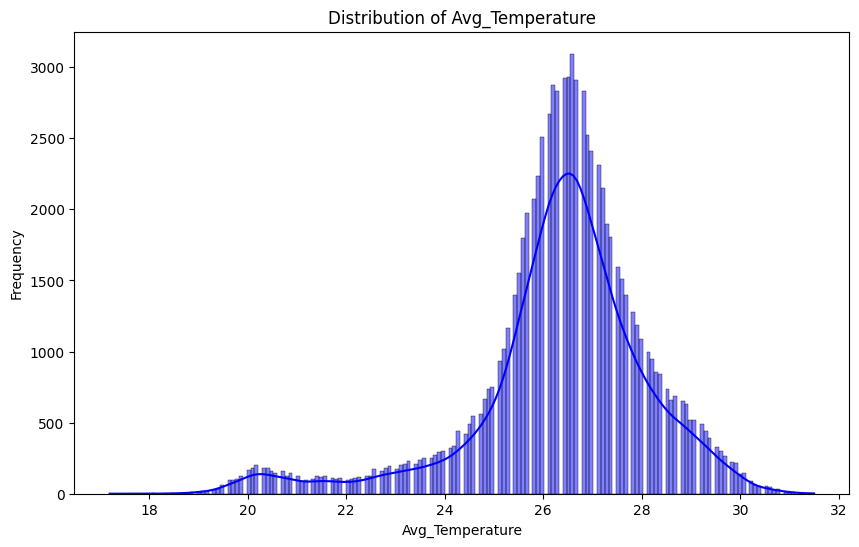

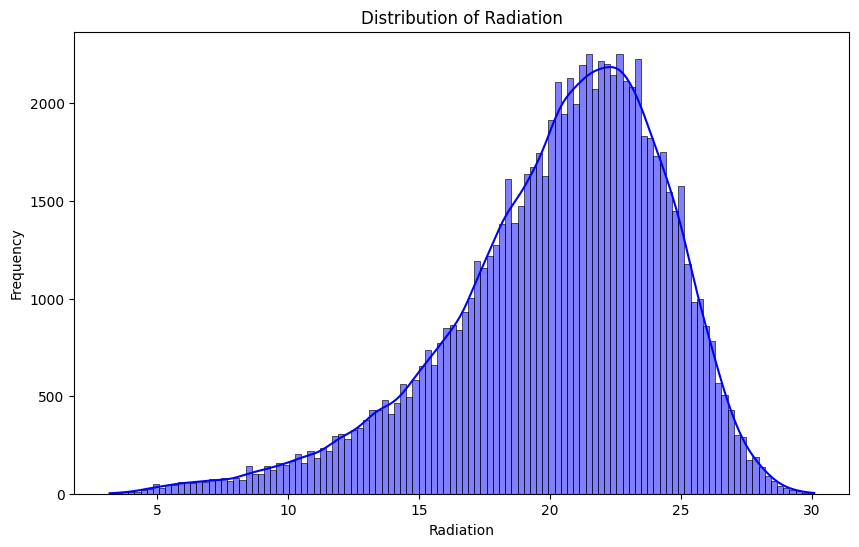

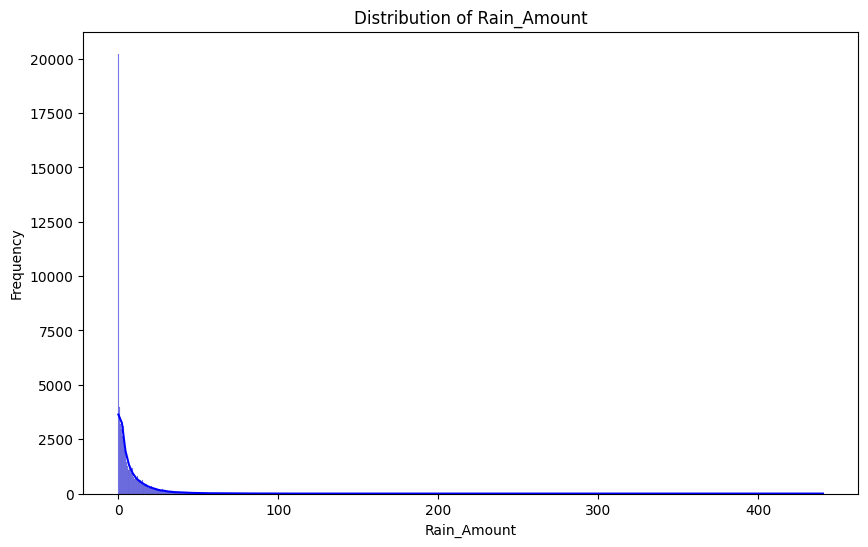

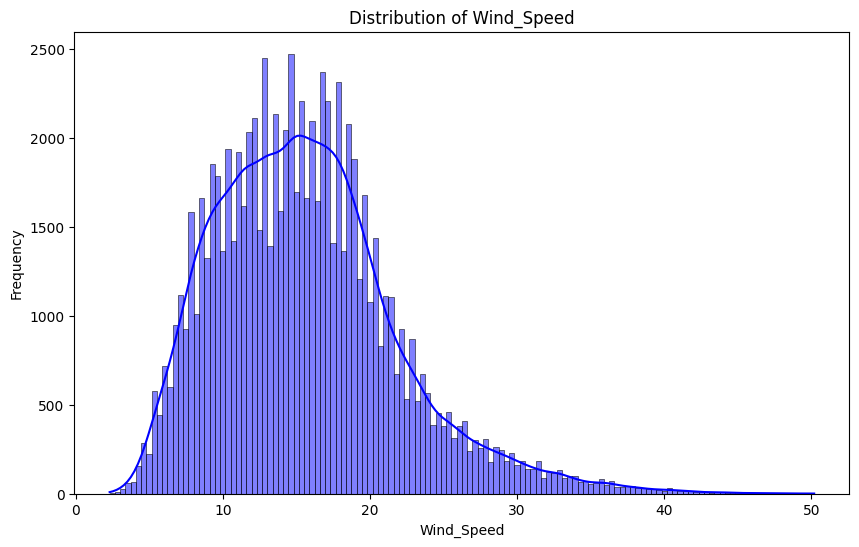

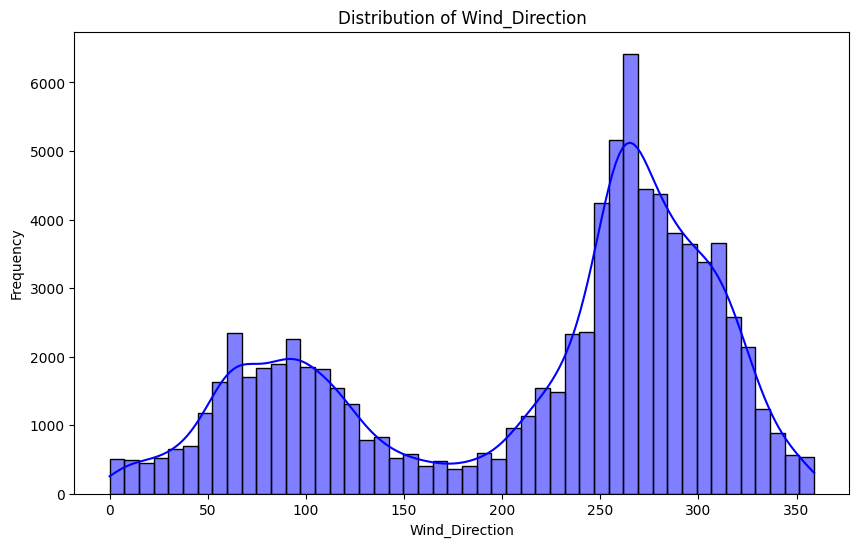

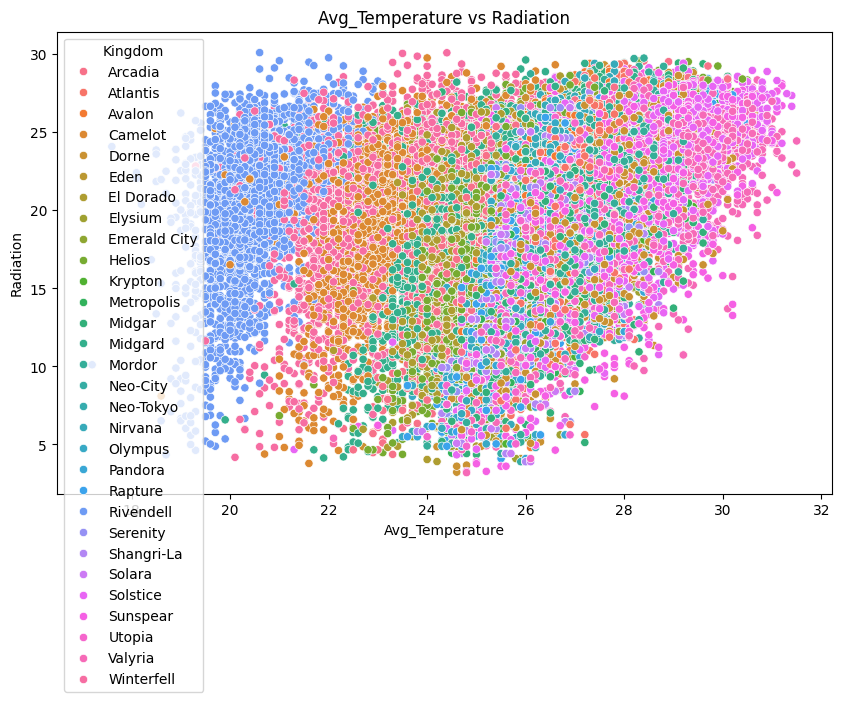

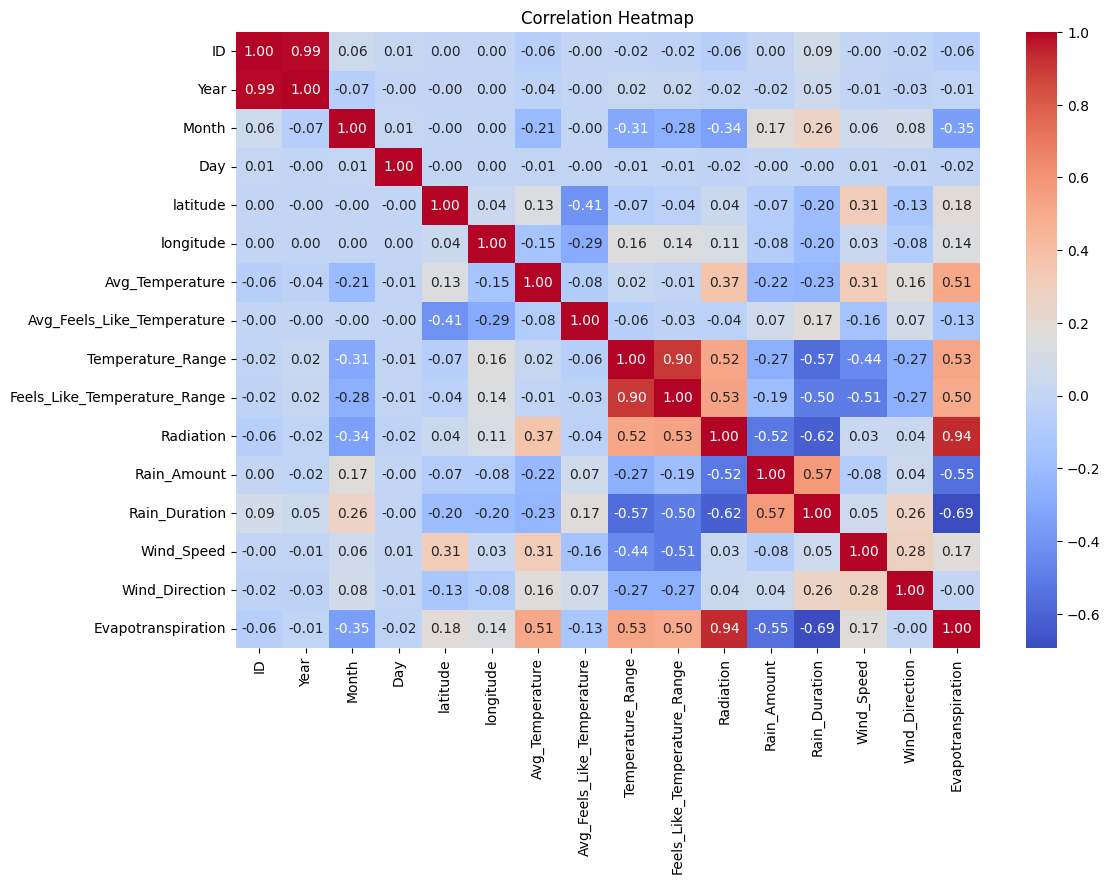

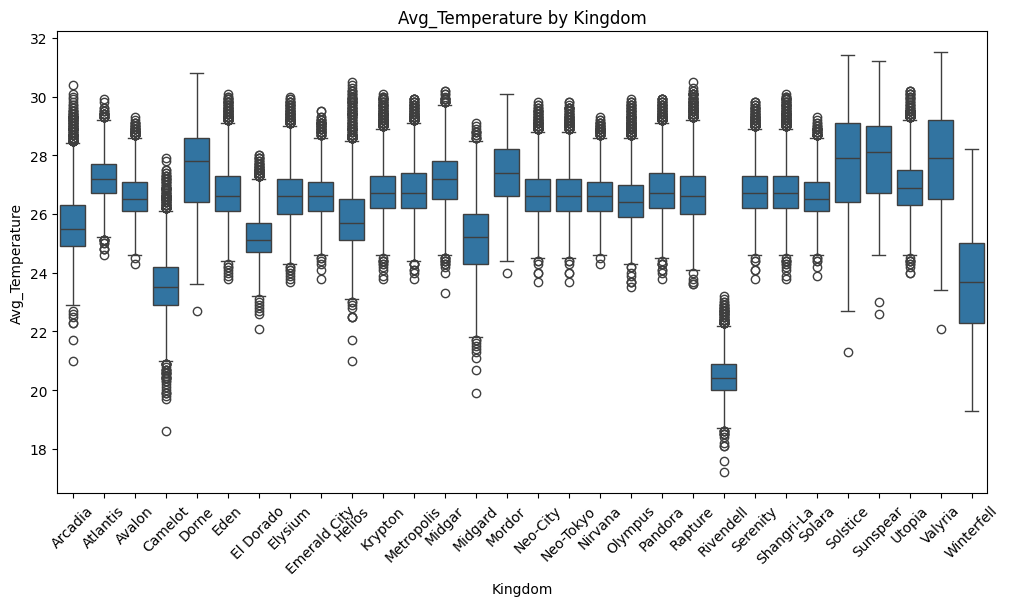

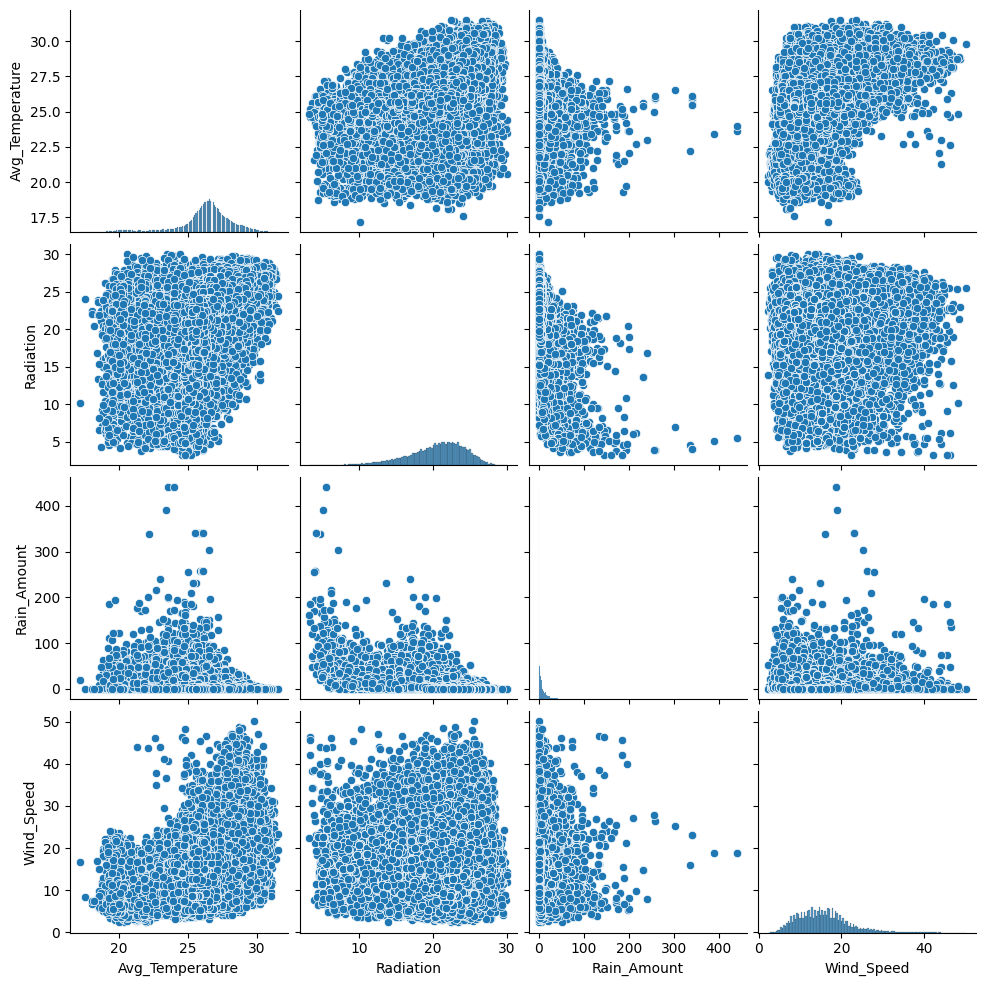

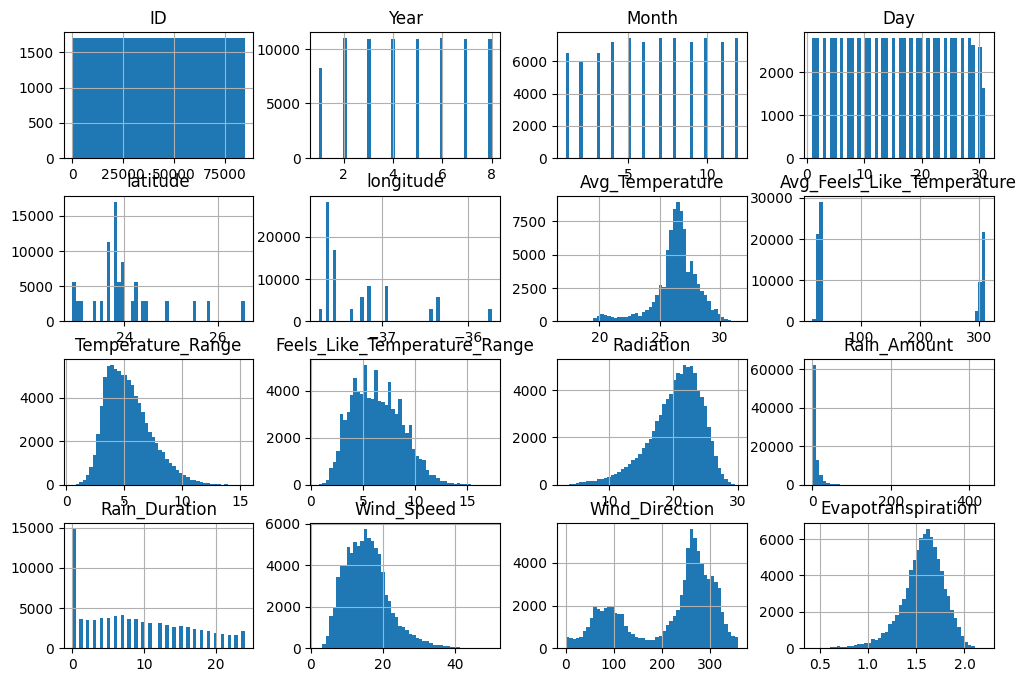

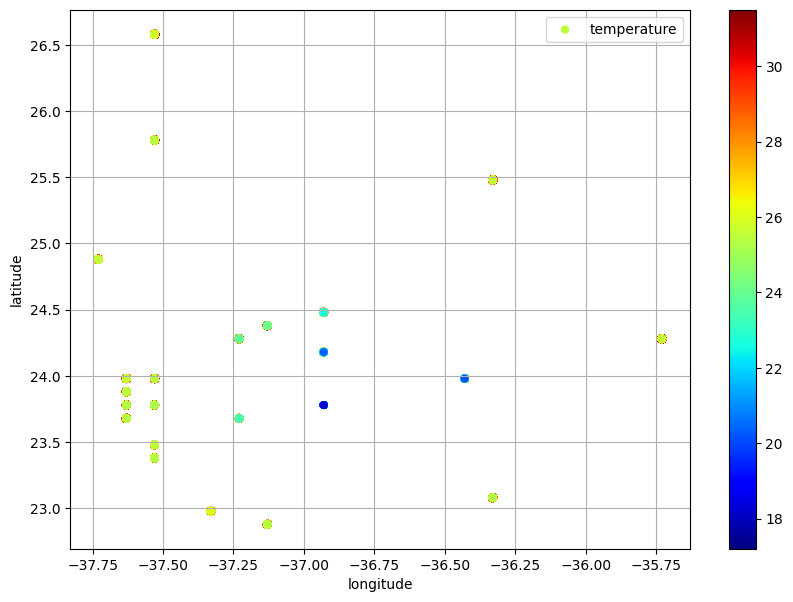

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data into a pandas DataFrame
data = pd.read_csv('./train.csv')  # Replace with the actual path to your data file

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())

# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

def kelvin_to_celsius(kelvin_temp):
    """Converts temperature in Kelvin to Celsius.
    Args:
        kelvin_temp: Temperature in Kelvin.
    Returns:
        Temperature in Celsius.
    """
    celsius_temp = kelvin_temp - 273.15
    return celsius_temp

# Assume 'df' is your DataFrame and 'Avg_Temperature' is the column
# Replace outlier_condition with your logic to identify Kelvin values
data['Avg_Temperature'] = np.where(data['Avg_Temperature'] > 270,
                                      data['Avg_Temperature'].apply(kelvin_to_celsius),
                                      data['Avg_Temperature'])

# Visualize the distribution of Avg_Temperature
plt.figure(figsize=(10, 6))
sns.histplot(data['Avg_Temperature'], kde=True, color='blue')
plt.title('Distribution of Avg_Temperature')
plt.xlabel('Avg_Temperature')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Radiation
plt.figure(figsize=(10, 6))
sns.histplot(data['Radiation'], kde=True, color='blue')
plt.title('Distribution of Radiation')
plt.xlabel('Radiation')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Rain_Amount
plt.figure(figsize=(10, 6))
sns.histplot(data['Rain_Amount'], kde=True, color='blue')
plt.title('Distribution of Rain_Amount')
plt.xlabel('Rain_Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Wind_Speed
plt.figure(figsize=(10, 6))
sns.histplot(data['Wind_Speed'], kde=True, color='blue')
plt.title('Distribution of Wind_Speed')
plt.xlabel('Wind_Speed')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Wind_Direction
plt.figure(figsize=(10, 6))
sns.histplot(data['Wind_Direction'], kde=True, color='blue')
plt.title('Distribution of Wind_Direction')
plt.xlabel('Wind_Direction')
plt.ylabel('Frequency')
plt.show()


# Scatter plot for Avg_Temperature vs Radiation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Temperature', y='Radiation', hue='kingdom', data=data)
plt.title('Avg_Temperature vs Radiation')
plt.xlabel('Avg_Temperature')
plt.ylabel('Radiation')
plt.legend(title='Kingdom')
plt.show()



# Correlation heatmap
plt.figure(figsize=(12, 8))

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplot for Avg_Temperature by Kingdom
plt.figure(figsize=(12, 6))
sns.boxplot(x='kingdom', y='Avg_Temperature', data=data)
plt.title('Avg_Temperature by Kingdom')
plt.xlabel('Kingdom')
plt.ylabel('Avg_Temperature')
plt.xticks(rotation=45)
plt.show()

# Pairplot for selected features
selected_features = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed']
sns.pairplot(data[selected_features])
plt.show()

data.hist(bins=50, figsize=(12, 8))
plt.show()

data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=data["Avg_Temperature"]/100 , label="temperature" ,c=data["Avg_Temperature"], cmap="jet", colorbar=True,legend=True, sharex=False, figsize=(10, 7))
plt.show()

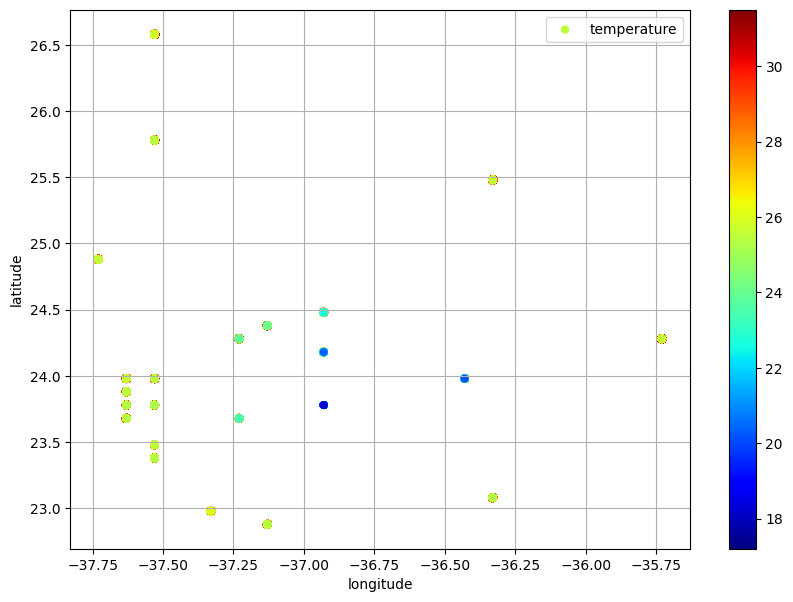

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=data["Avg_Temperature"] , label="temperature" ,c=data["Avg_Temperature"], cmap="jet", colorbar=True,legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [ ]:
data.to_csv('cleaned_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_data.csv'")


Cleaned data saved to 'cleaned_data.csv'


<ipython-input-27-843be407bf94>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))


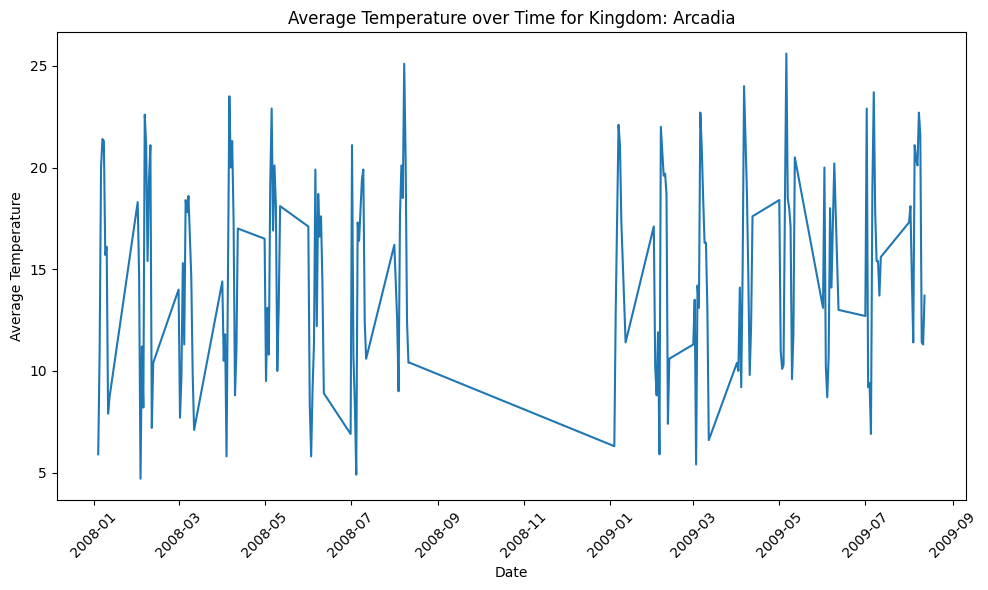

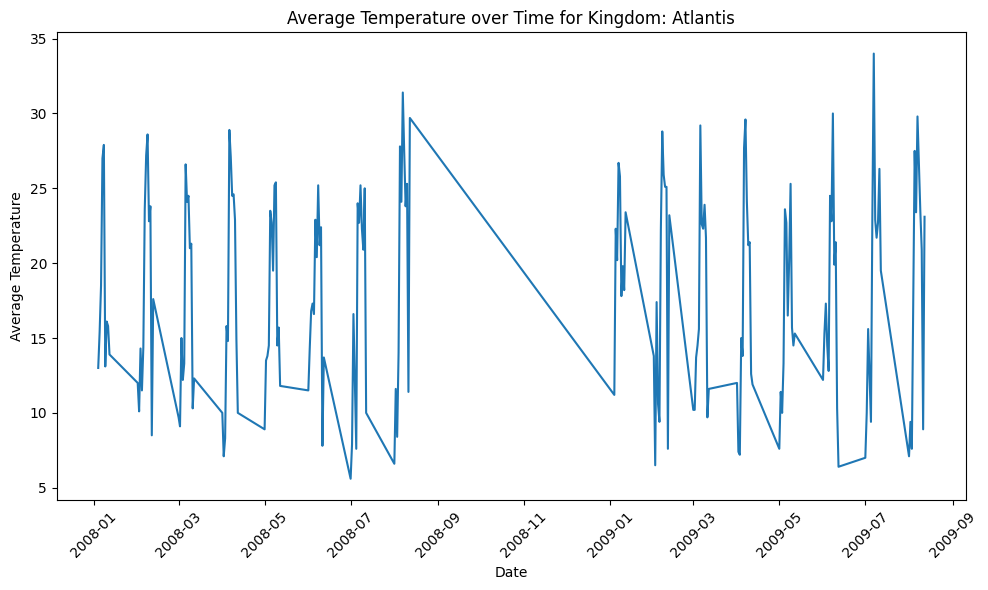

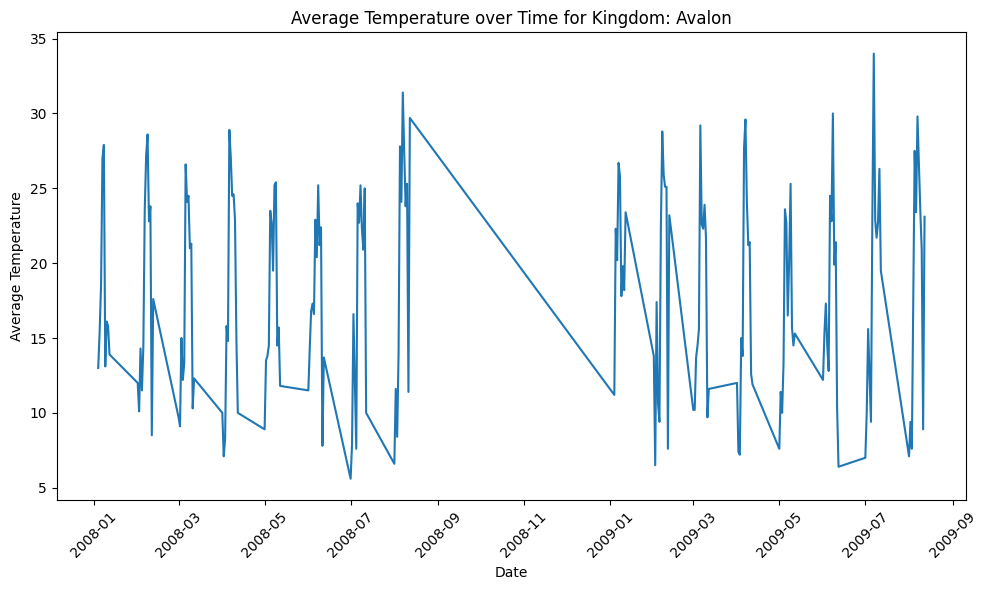

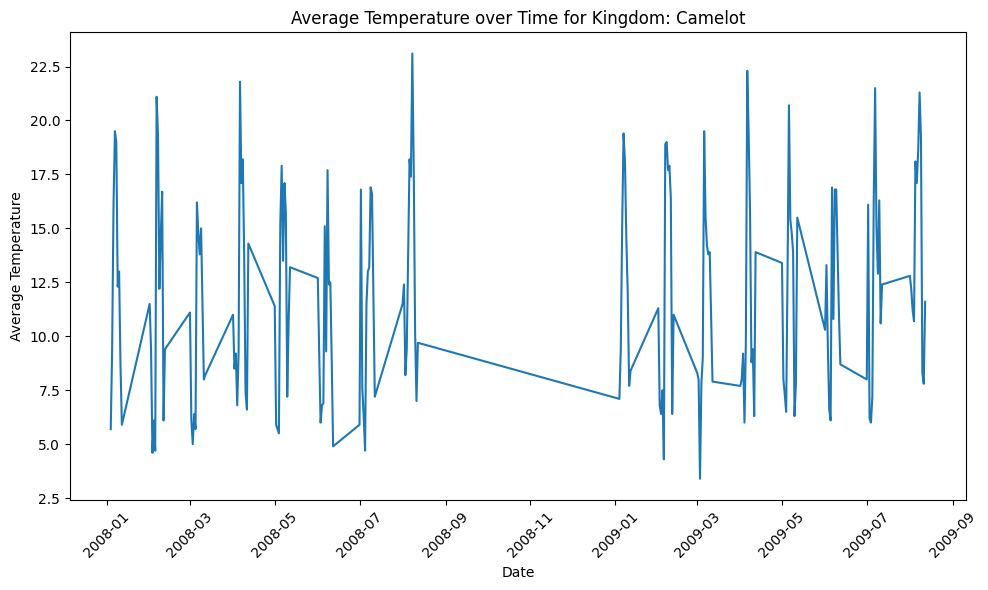

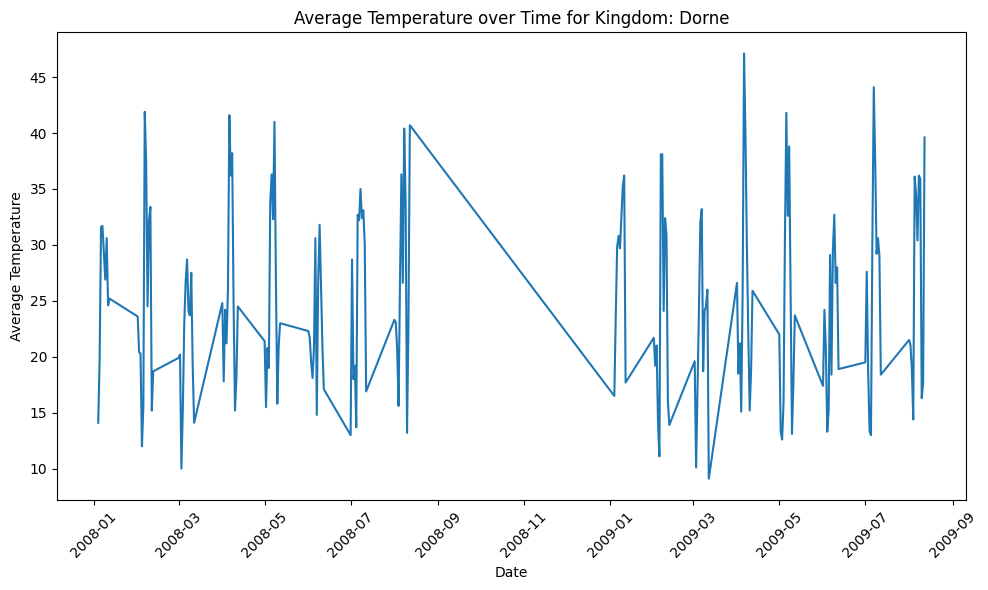

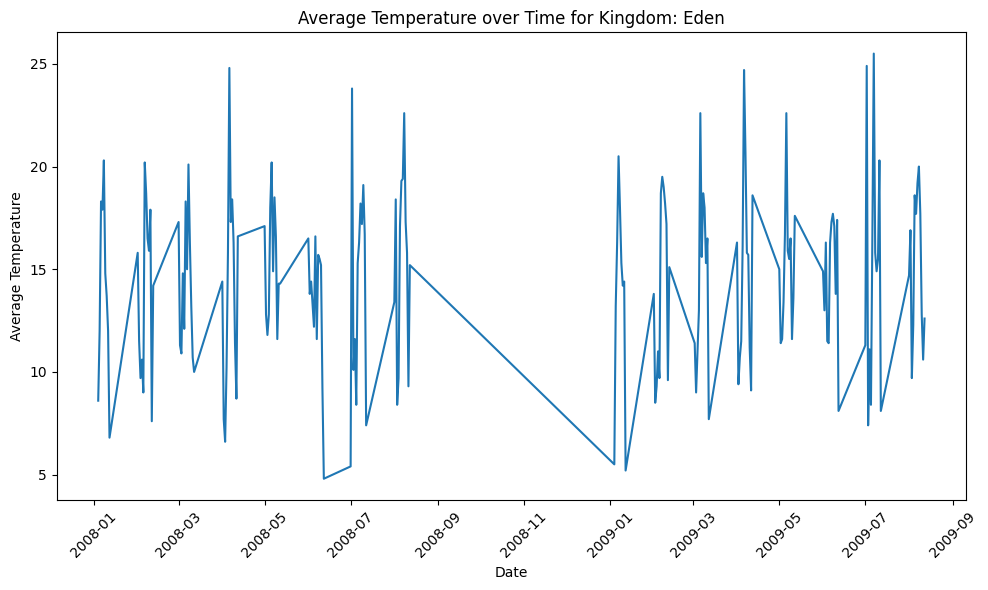

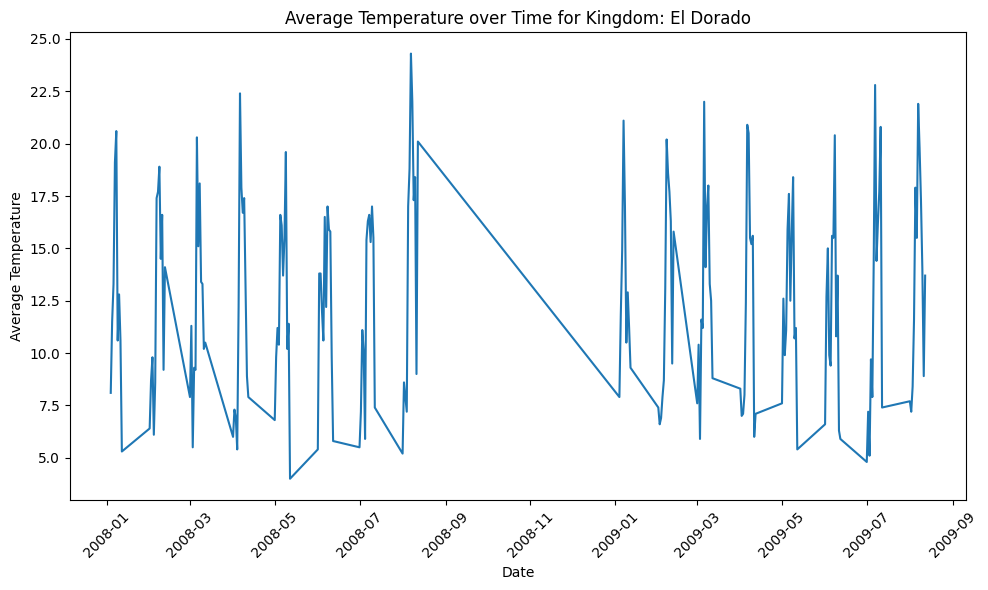

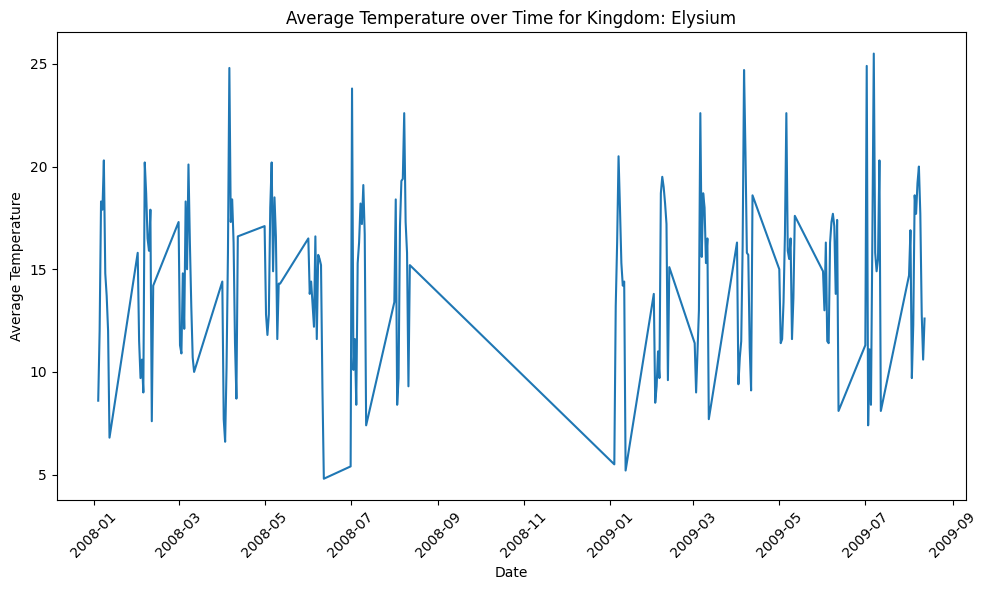

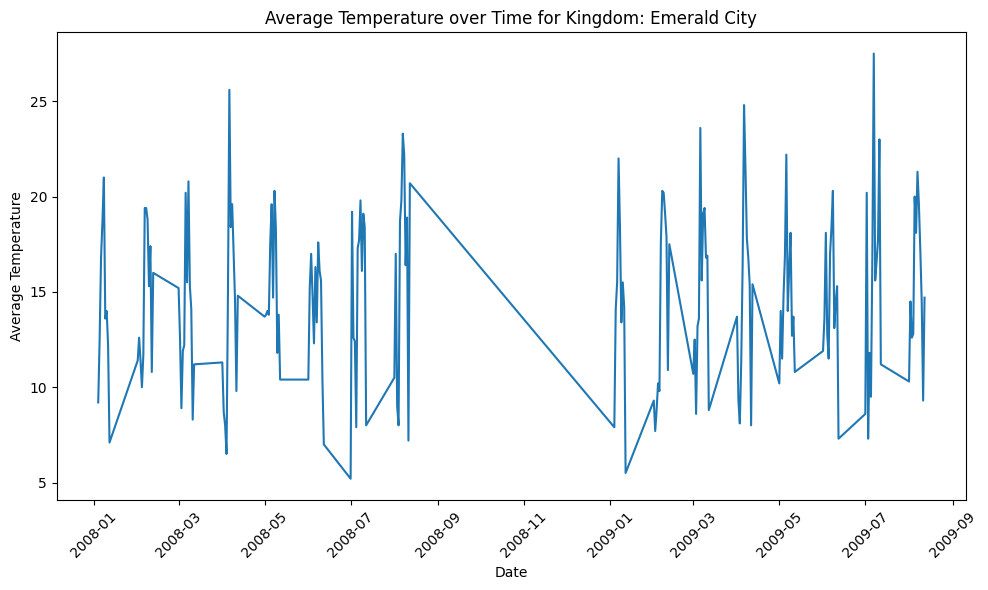

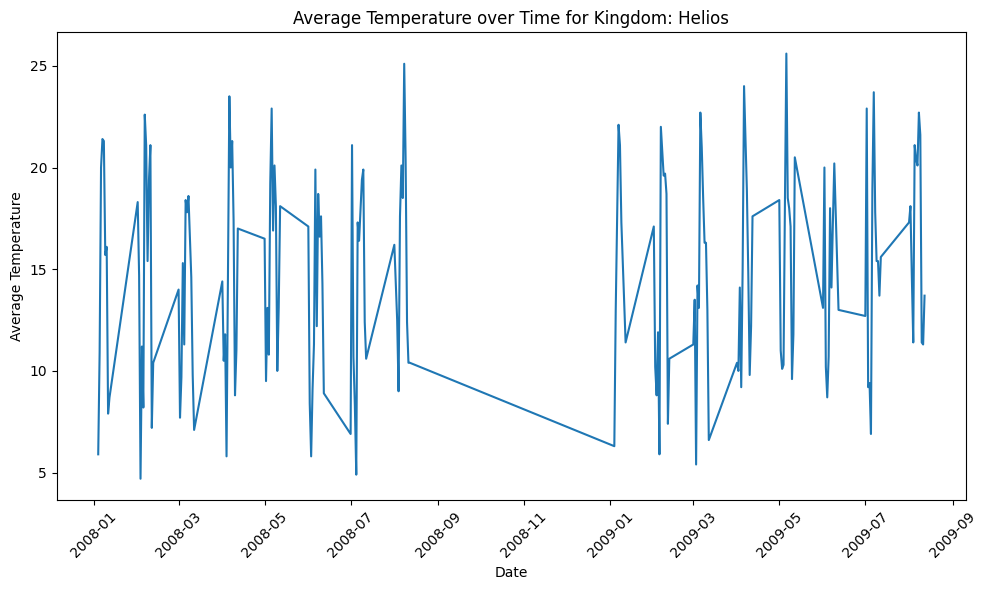

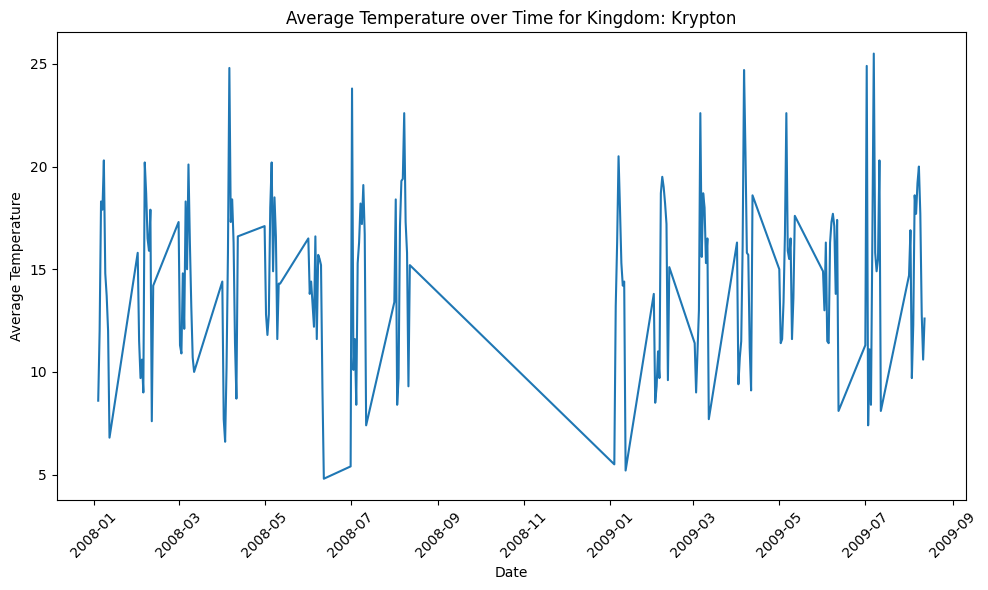

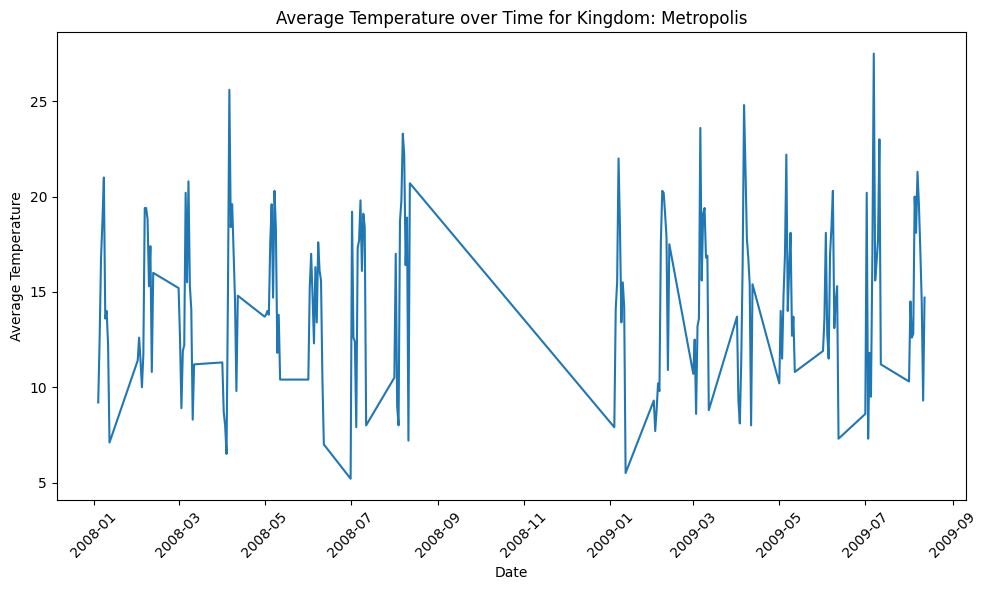

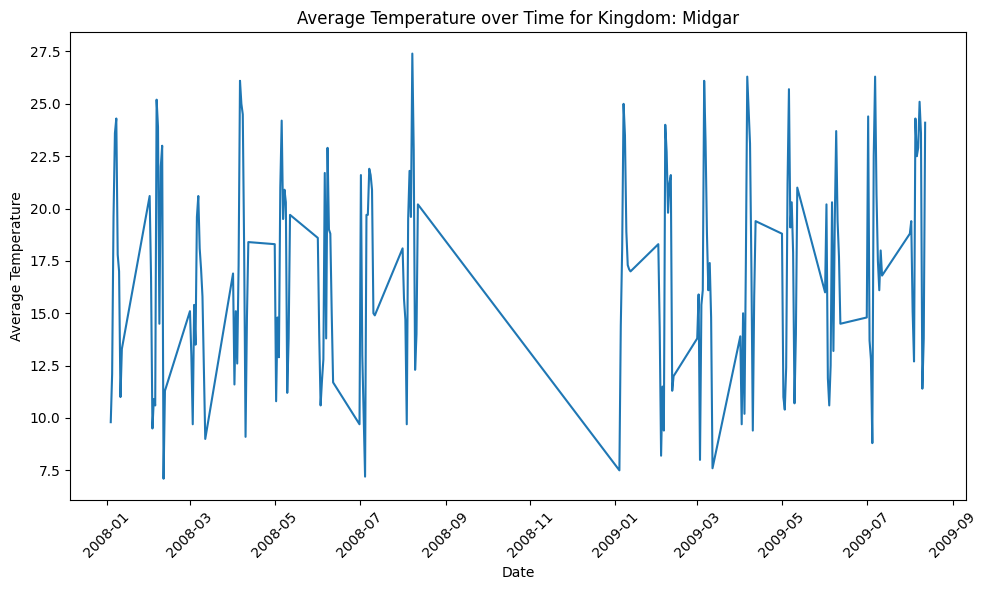

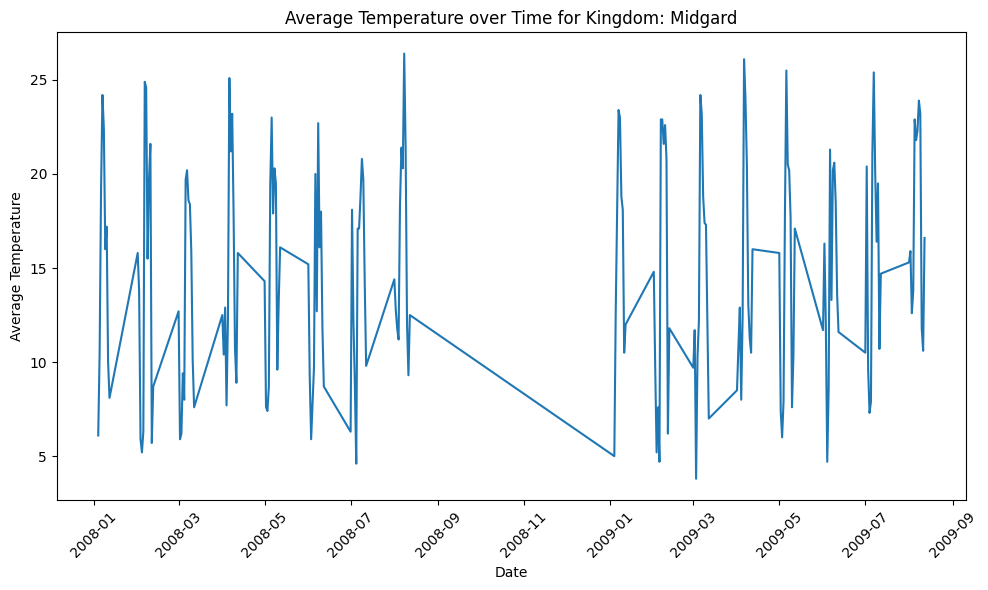

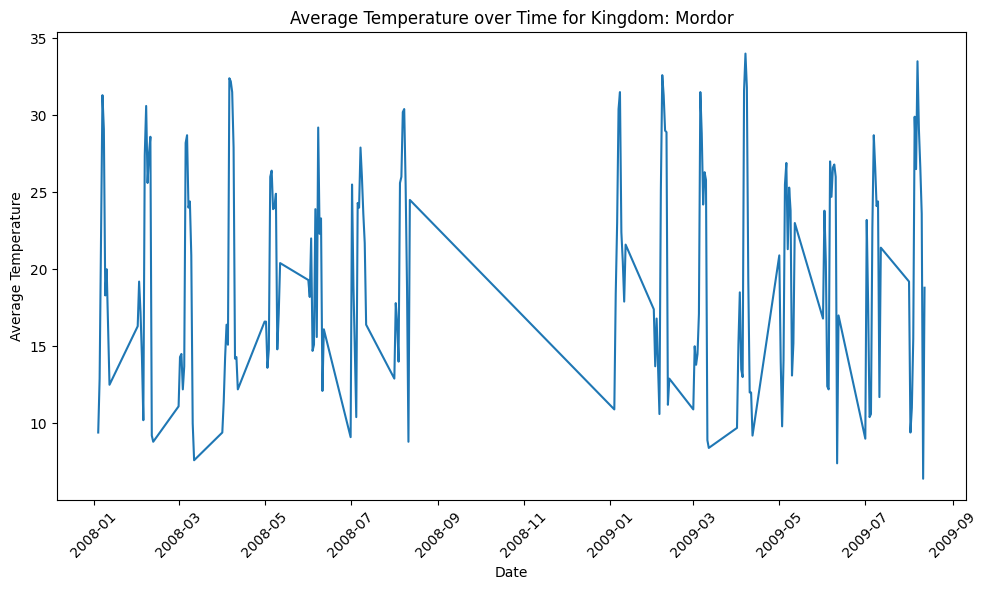

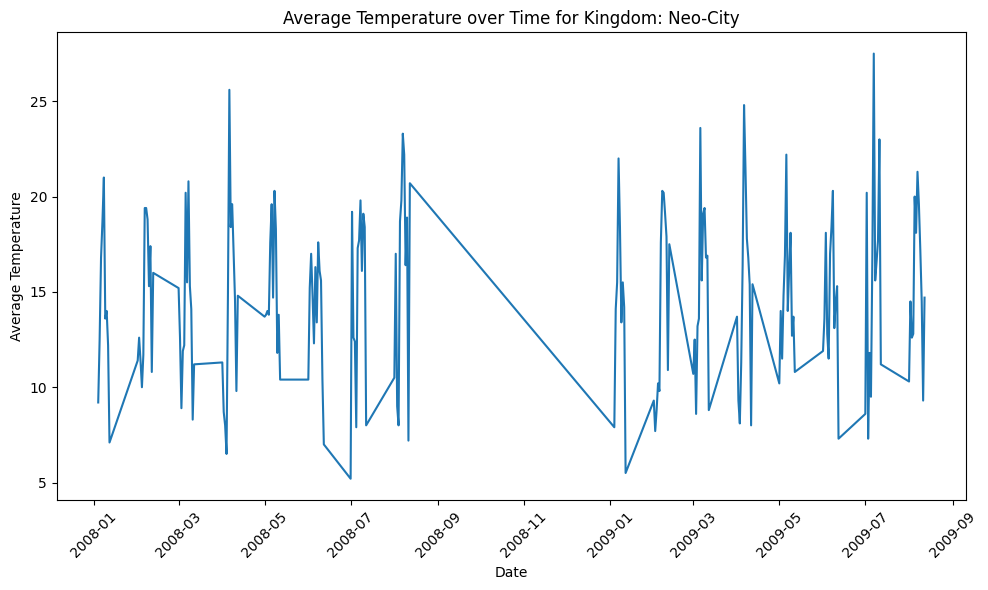

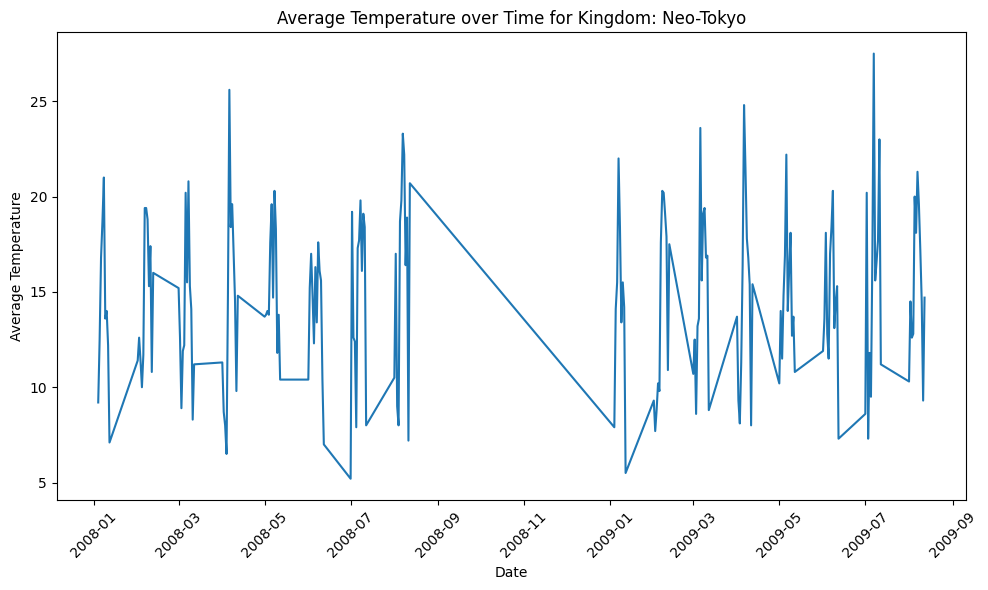

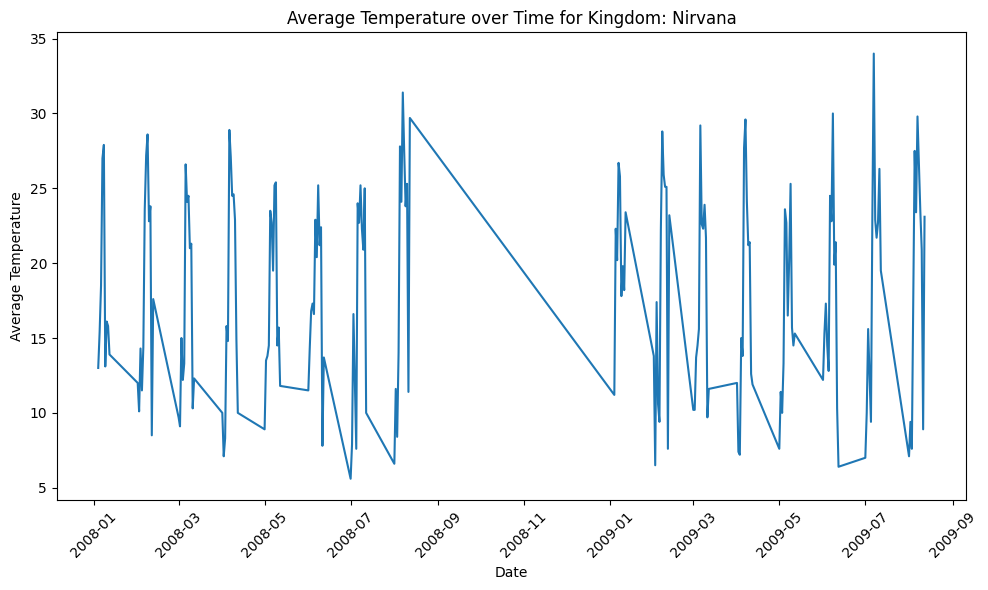

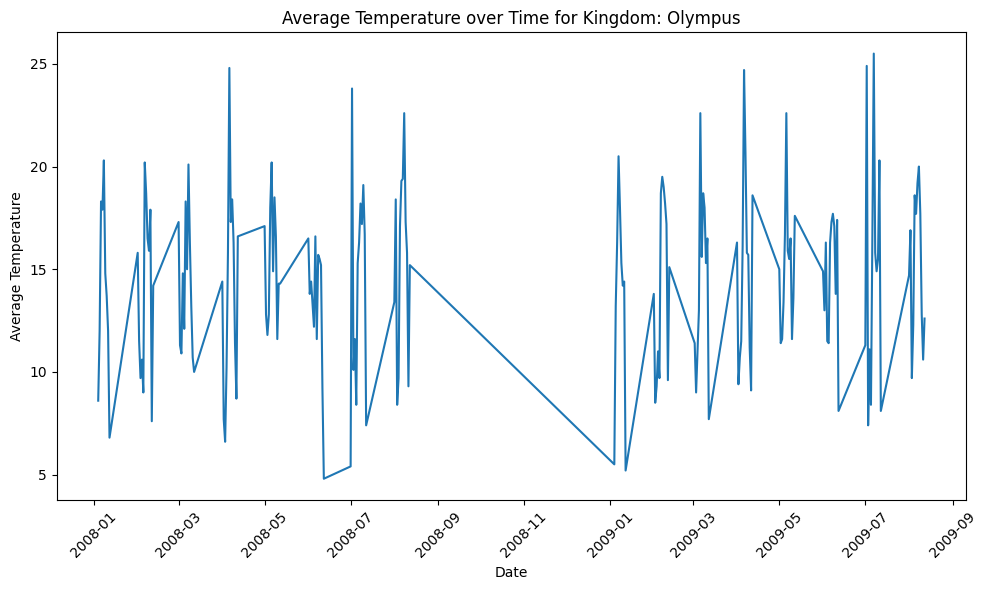

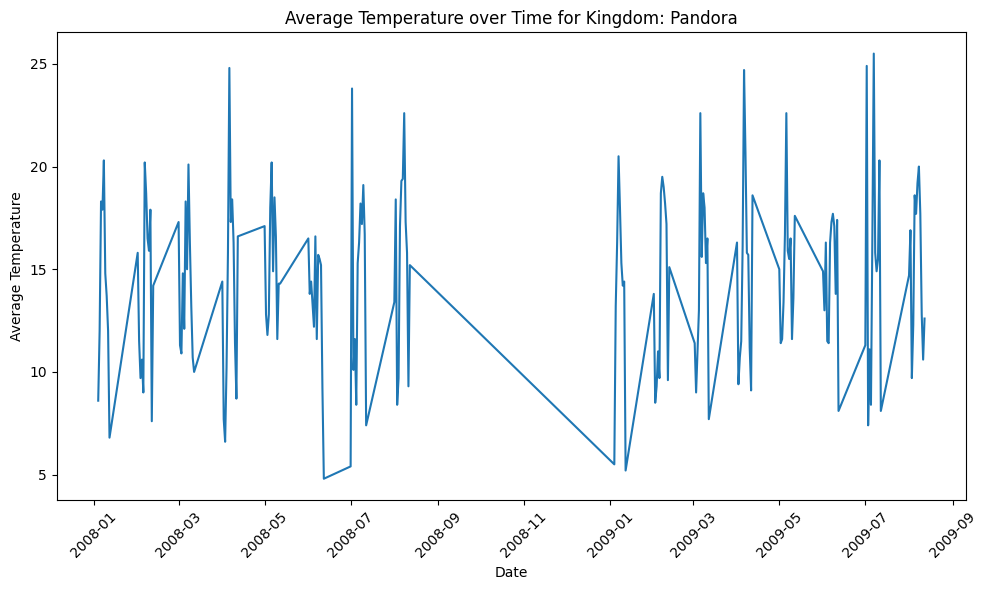

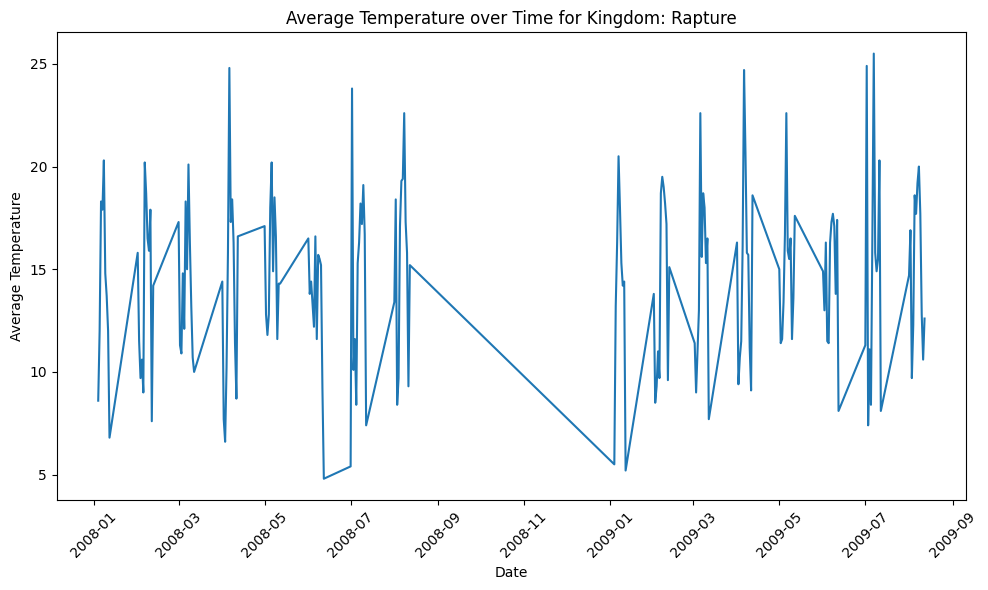

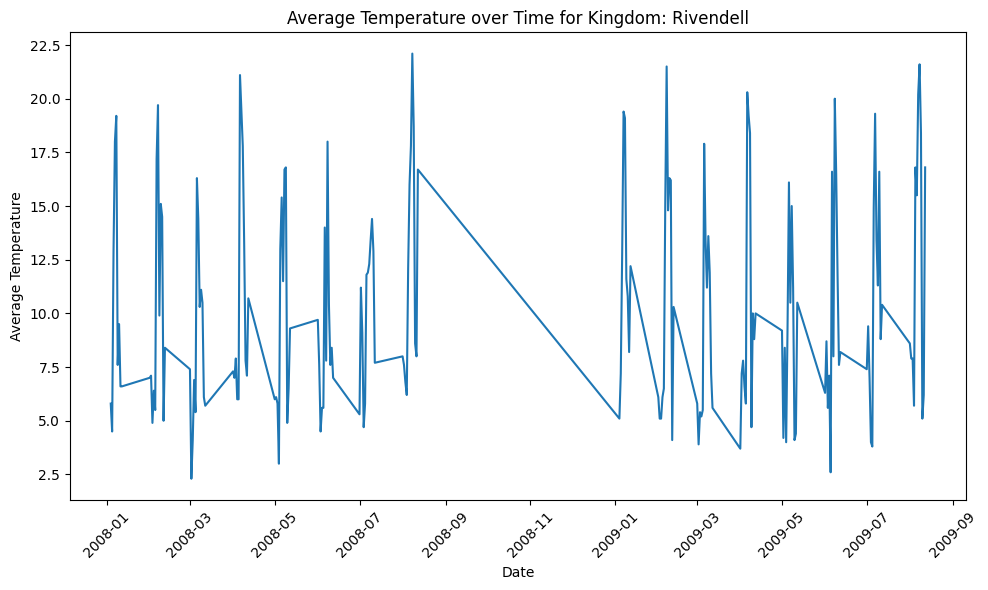

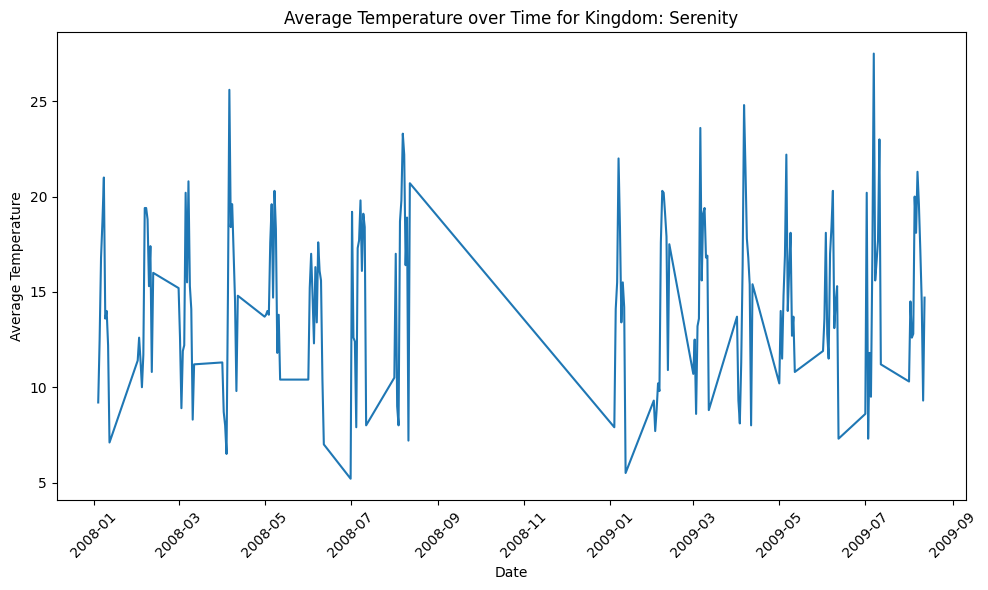

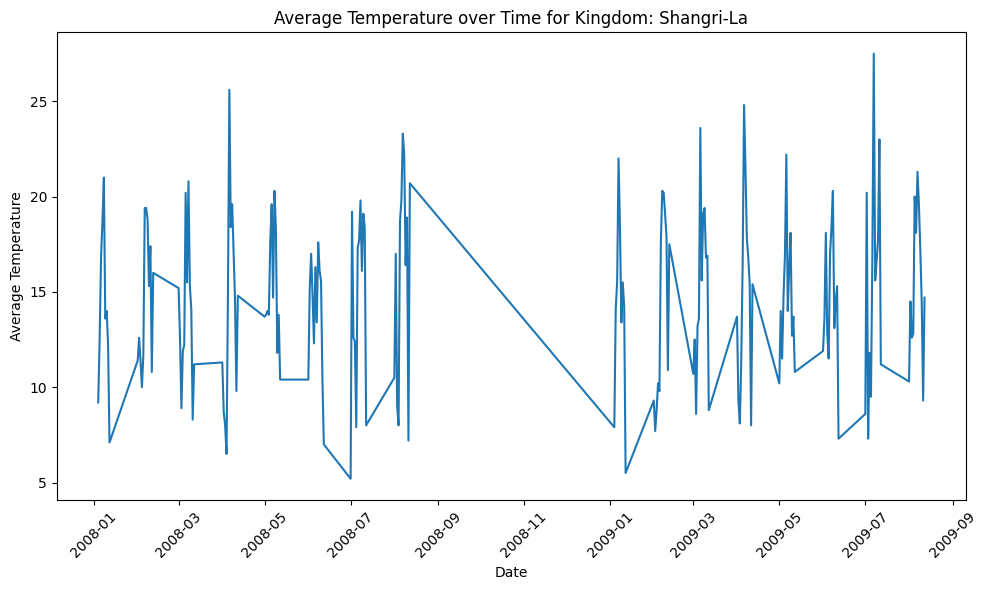

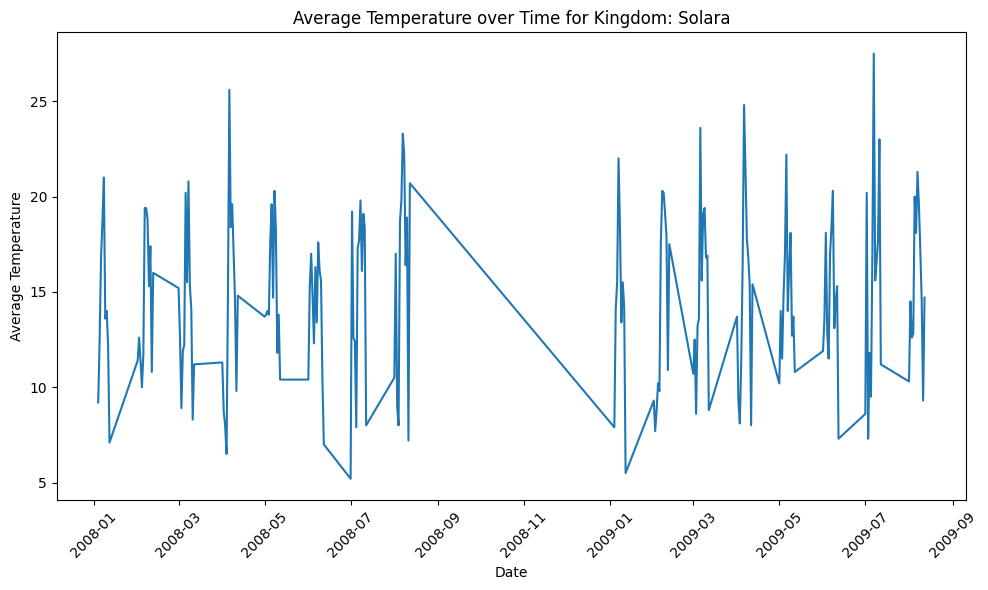

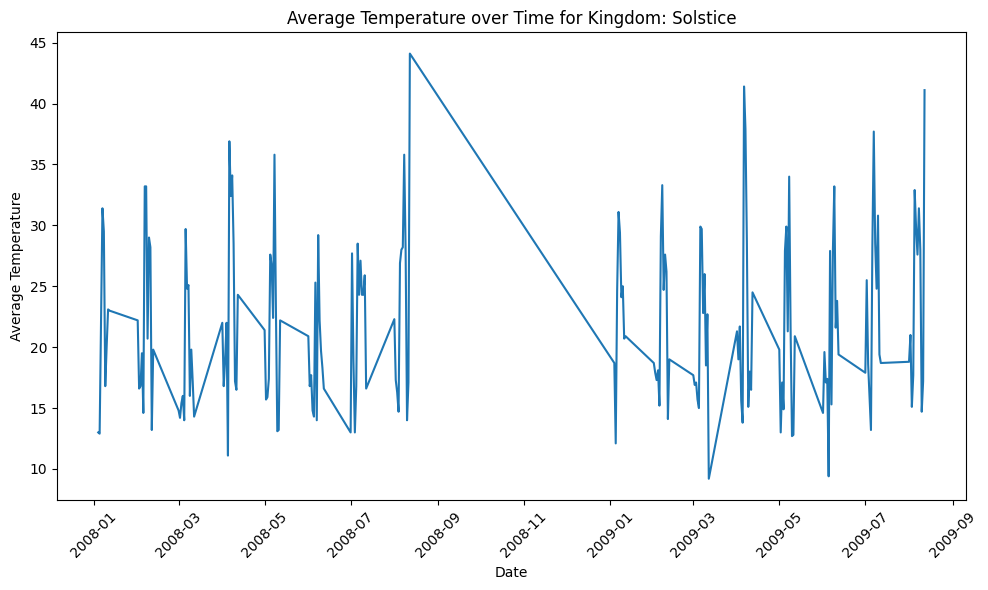

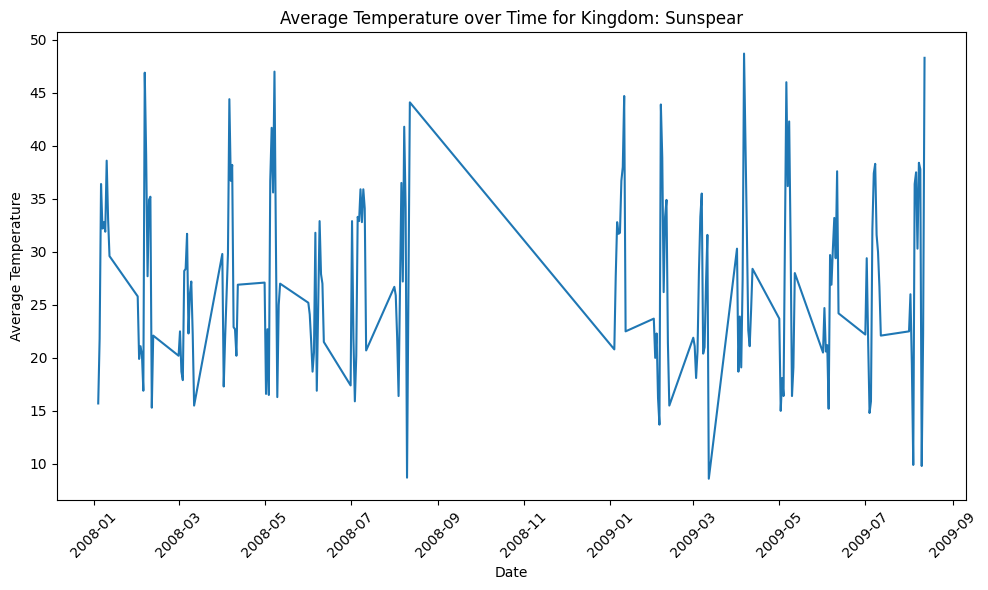

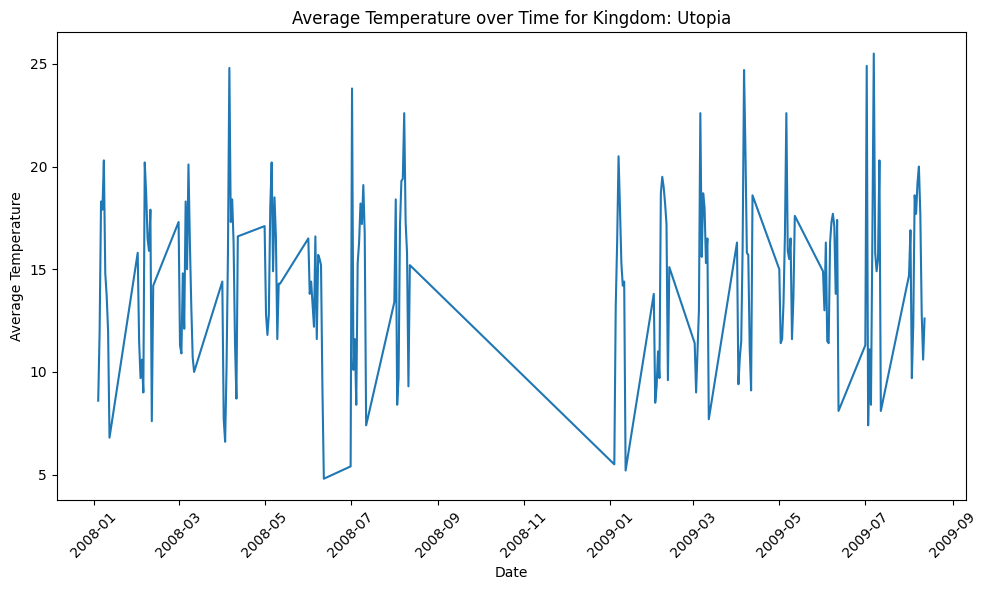

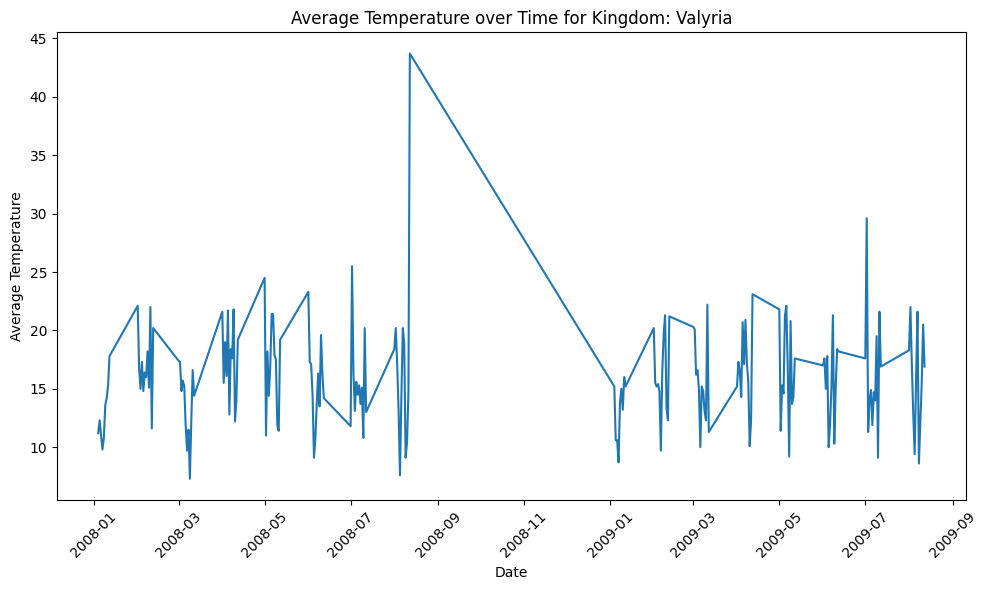

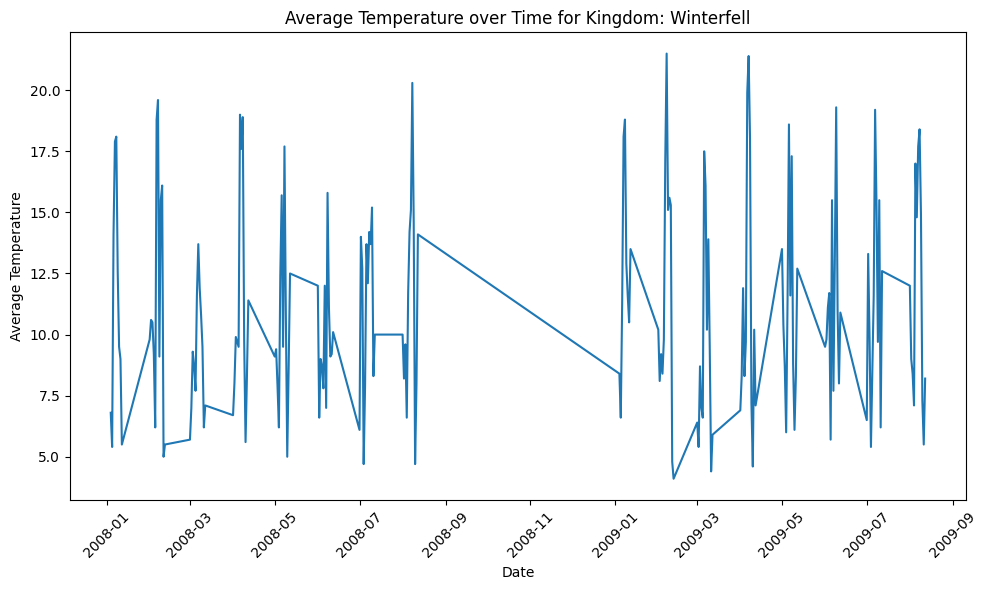

In [ ]:
3# prompt: Write me a code to generate time series graphs for each kingdom using python and matplotlib
# Date is in 3 columns as (Year         Month           Day)
# I said there isn't a column called Date. instead of it there are three columns as year, month, day

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("cleaned_data.csv")  # Replace with your actual file path

# Convert Year, Month, Day to datetime
# Convert Year, Month, Day to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))
# Group data by kingdom and date
df = df[(df['date'].dt.year >= 2008) & (df['date'].dt.year <= 2009)]

kingdom_groups = df.groupby('kingdom')

# Iterate through each kingdom
for kingdom, data in kingdom_groups:
    # Sort the data by date

    data = data.sort_values(by='date')

    # Plot the time series for Avg_Temperature
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data['Wind_Speed'])
    plt.title(f'Average Temperature over Time for Kingdom: {kingdom}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\cleaned_data.csv")

# Sorting
df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df, columns=['kingdom'], drop_first=True)

# Select Features & Targets
X = df[['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
Y = df[['Avg_Temperature','Radiation', 'Rain_Amount','Wind_Speed', 'Wind_Direction']].values

# Normalize Features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Prepare Sequential Data
time_steps = 30
X_seq, Y_seq = [], []

for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])
    Y_seq.append(Y[i+time_steps])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# ------------------------------- #
# Build CNN-LSTM-Attention Model
# ------------------------------- #

# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
cnn_output = Flatten()(pool2)

# LSTM Layer
lstm_layer = LSTM(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, lstm_layer])
attention_output = GlobalAveragePooling1D()(attention_layer)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn_output, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(5)(dense2)  # Predicting 5 variables

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Isitha\\Downloads\\cleaned_data.csv'